# Metric Calculation
Calculate metrics for models run on the full dataset

In [96]:
import xgboost
from xgboost import plot_importance
from bgpredict.helpers import S3Connection
from dotenv import load_dotenv
import multiprocessing
import json
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import sqlalchemy
from sqlalchemy import create_engine
from datetime import datetime
from skopt import BayesSearchCV, dump, load
from skopt.plots import plot_objective, plot_histogram
import matplotlib.pyplot as plt 

In [9]:
os.chdir('../')
load_dotenv()
os.chdir('./Baseline')

In [97]:
def clean_data(df):
    # Drop rows with no Y value
    df = df.dropna(subset='bg')

    # Fill nulls (lag BG values) with 0 to indicate data is unavailable
    print(f"Null values to be filled by column:")
    nulls = df.isna().sum()
    null_idx = list(nulls.index)
    vals = list(nulls)
    for col, val in list(zip(null_idx, vals)):
        if val > 0:
            print(col, val)
    df = df.fillna(0)

    # Sort by timestamp
    current_len = len(df)
    df = df.loc[~(df['timestamp_clean'].apply(type) == int), :]
    print(f"Dropping {current_len - len(df)} invalid timestamps")
    df = df.sort_values(by="timestamp_clean")

    # Set index to time_stamp_clean
    df.index = df['timestamp_clean']
    df = df.drop(labels=['timestamp_clean'], axis=1)

    # Drop first row by subject which has data quality issues
    df = df[df.groupby('subjectid').cumcount() > 0]

    # Drop columns that are indices, irrelevant, or capture in OHE variables
    drop_cols = ['timestamp', 'date', 'time']
    df = df.drop(labels=drop_cols, axis=1)

    # One hot Encode Weekdays
    weekdays = np.unique(df['weekday'])
    ohe_weekdays = [f"ohe_{day}" for day in weekdays]
    df[ohe_weekdays] = pd.get_dummies(df.weekday)
    df = df.drop(labels="weekday", axis=1)

    return df

In [98]:
location = f"postgresql://postgres:{os.environ.get('db_password')}@{os.environ.get('db_location')}"
engine = create_engine(location)
conn = engine.connect()
raw_df = pd.read_sql("select * from public.vw_final_dataset where test_set = 1", conn)
clean_df = clean_data(raw_df)

Null values to be filled by column:
bg_lag_1 6593
bg_lag_2 6449
bg_lag_3 6420
bg_lag_4 6548
bg_lag_5 6614
bg_lag_6 6577
bg_lag_7 6653
bg_lag_8 6720
bg_lag_9 6683
bg_lag_10 6694
bg_lag_11 6746
bg_lag_12 6758
Dropping 0 invalid timestamps


In [7]:
s3_conn = S3Connection()

## Arima

In [20]:
arima_locs = s3_conn.s3_client.list_objects_v2(Bucket=s3_conn.bucket_name, Prefix="models/arima/")
arima_locs['Contents']
result_uris = []
for x in arima_locs["Contents"]:
    path = x['Key']
    if "results" in path:
        uri = f"s3://{s3_conn.bucket_name}/{path}"
        result_uris.append(uri)
result_dfs= []
for uri in result_uris:
    df = pd.read_csv(uri)
    df.columns = ['subjectid', 'entryid', 'y', 'y_hat']
    result_dfs.append(df)
result_dfs[0].head()

,subjectid,entryid,y,y_hat
0,12689381,575,154.0,145.398916
1,12689381,574,147.0,147.389779
2,12689381,573,140.0,148.096161
3,12689381,572,134.0,147.715828
4,12689381,571,130.0,146.491036


In [52]:
arima_df = pd.concat(result_dfs)

# There are 162 rows where y == 0 which artificially inflates MAPE
arima_df = arima_df.loc[arima_df['y'] != 0,:]
print(arima_df.shape)
arima_df.head()

(1253986, 4)


,subjectid,entryid,y,y_hat
0,12689381,575,154.0,145.398916
1,12689381,574,147.0,147.389779
2,12689381,573,140.0,148.096161
3,12689381,572,134.0,147.715828
4,12689381,571,130.0,146.491036


In [73]:
test = arima_df.loc[arima_df['y_hat'] > 1000, :]
erroneous_subject =np.unique(test['subjectid'])[0]
print(erroneous_subject)
test.describe()

93839818


,subjectid,entryid,y,y_hat
count,13508.0,13508.000000,13508.000000,13508.000000
mean,93839818.0,201722.300933,120.995114,1932.249169
std,0.0,8532.815657,54.468599,538.248621
min,93839818.0,187136.000000,38.000000,1000.078731
25%,93839818.0,194159.500000,83.000000,1466.163950
50%,93839818.0,202201.000000,110.000000,1932.249169
75%,93839818.0,209226.500000,147.000000,2398.334388
max,93839818.0,216135.000000,400.000000,2864.419607


Subject 93839818's predictions are erroneous. Drop this subject when evaluating ARIMA metrics.

In [74]:
arima_df = arima_df.loc[arima_df['subjectid'] != erroneous_subject]

In [110]:
full_mse = mean_squared_error(arima_df['y'], arima_df['y_hat'])
full_rmse = np.sqrt(mse)
full_mae = mean_absolute_error(arima_df['y'], arima_df['y_hat'])
full_mape = mean_absolute_percentage_error(arima_df['y'], arima_df['y_hat'])
print(f'MSE: {full_mse}')
print(f'RMSE: {full_rmse}')
print(f'MAE: {full_mae}')
print(f'MAPE: {full_mape}')
full_metrics = {'rmse':full_rmse, "mae": full_mae, "mape": full_mape}

MSE: 8117.6496236625935
RMSE: 53.574637424497695
MAE: 57.78072210054919
MAPE: 0.5339585423736942


In [121]:
metrics = {'rmse':[], "mae": [], "mape": []}
grouped = arima_df.groupby('subjectid')
for name, group in grouped:
    mse = mean_squared_error(group['y'], group['y_hat'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(group['y'], group['y_hat'])
    mape = mean_absolute_percentage_error(group['y'], group['y_hat'])
    metrics['rmse'].append(rmse)
    metrics['mae'].append(mae)
    metrics['mape'].append(mape)

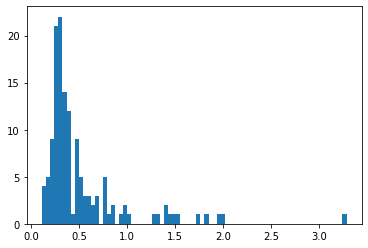

In [96]:
_= plt.hist(metrics['mape'], bins=75)

In [122]:
for i, j in enumerate(metrics):
    print(i,j)

0 rmse
1 mae
2 mape


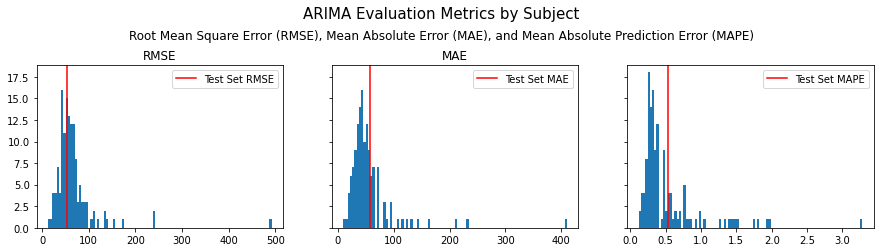

In [178]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(15,3))

indices = [(0,0), (0,1),(0,2)]
for idx, key in enumerate(metrics):
    ax = axs[idx]
    ax.hist(metrics[key], bins=100)
    ax.set_title(f"{key.upper()}")
    ax.axvline(full_metrics[key], color='red', label=f'Test Set {key.upper()}')
    ax.legend()
_ = plt.suptitle('ARIMA Evaluation Metrics by Subject', y=1.15, fontsize=15)
_ = plt.title('Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Prediction Error (MAPE)',
              x=0.5, transform=fig.transFigure, fontsize=12)

(-100.0, 600.0)

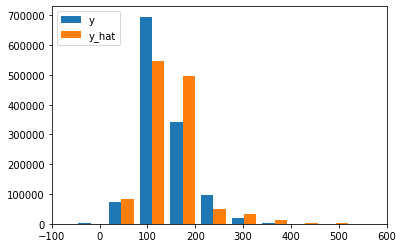

In [182]:
# _ = plt.hist(arima_df['y_hat'], bins=20, color='red')
_ = plt.hist([arima_df['y'], arima_df['y_hat']], bins=20, label = ['y', 'y_hat'])
plt.legend(loc="upper left")
plt.xlim(-100, 600)

In [176]:
arima_df[['y', 'y_hat']]

y        0
y_hat    0
dtype: int64

## XGBoost

### XGBoost Load

In [4]:
model_loc =  "models/xgboost/02.11.36.475845_L4607592"
# model_json = s3_conn.s3_client.get_object(Bucket=s3_conn.bucket_name, Key=estimator_loc)
# model_bytes = model_json['Body']
# type(model_txt)

In [5]:
from s3fs.core import S3FileSystem

In [10]:
fs = S3FileSystem()
bst = xgboost.XGBRegressor()

path = "./model.json"
with fs.open(f"bgpredict/{model_loc}", 'rb') as f:
    bst.load_model(bytearray(f.read()))

### XGBoost Feature Importance

In [72]:
gain = bst.get_booster().get_score(importance_type='gain')
covers = bst.get_booster().get_score(importance_type='cover')
freq = bst.get_booster().get_score(importance_type='weight')

In [94]:
importances = list(zip(bst.feature_names_in_, bst.feature_importances_))
weekday = 0
subjectid = 0 
other = []
for x in importances:
    if 'ohe' in x[0]:
        indicator = x[0].split("_")[1]
        try:
            int(indicator)
            subjectid += x[1]
        except:
            weekday += x[1]
    else:
        key = x[0]
        if key == "normalized_carbs_datapercentile":
            k = "Carb Data Rank"
        elif key == "normalized_insulin_datapercentile":
            k = "Insulin Data Rank"
        elif key == "carbs_datacount":
            k = "Recorded Carb Count"
        elif key == "insulin_datacount":
            k = "Recorded Insulin Count"
        elif key == "datediff_currentbg_lastbg_inseconds":
            k = "Time Since Last BG"
        else:
            k = key.replace("_", " ")
        
        other.append((k, x[1]))
other.append(("Weekday Effects", weekday))
other.append(("Subject Effects", subjectid))
other.sort(key=lambda x: x[1])
# other

Text(0.5, 1.0, 'XGBoost Feature Importance')

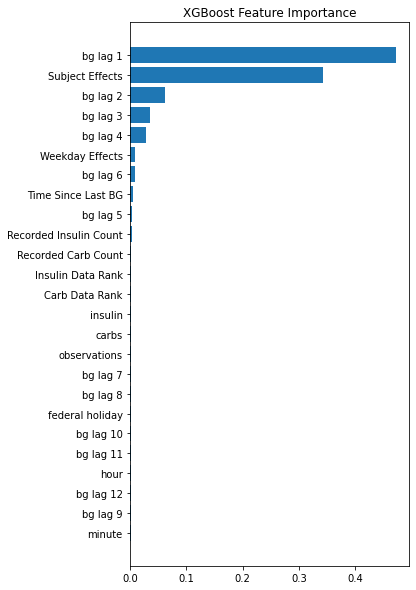

In [95]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(y=[x[0] for x in other], width=[x[1] for x in other])
plt.title("XGBoost Feature Importance")

### XGBoost Metrics

In [104]:
clean_cols = list(clean_df.columns)
features = bst.feature_names_in_
for i in clean_cols:
    if i not in features:
        print(i)

subjectid
entryid
train_set
test_set
validation_set
bg


In [105]:
drop_cols = ['train_set', 'validation_set', 'test_set', 'subjectid', 'entryid', 'bg']
pred_df = clean_df.drop(drop_cols, axis=1)
preds = bst.predict(pred_df)

0          182.471954
1          192.619751
2          191.927048
3          177.449188
4          172.775406
              ...    
1305550    135.278976
1305551    130.335175
1305552    126.889259
1305553    120.187225
1305554    117.611771
Name: y_hat, Length: 1305555, dtype: float32

In [118]:
clean_df.loc[: , ['subjectid', 'entryid', 'bg']].reset_index()

,subjectid,entryid,bg
timestamp_clean,,,
2016-08-10 00:43:50.664,68267781,43948,196.0
2016-08-10 00:48:51.032,68267781,43947,197.0
2016-08-10 01:13:49.950,68267781,43942,184.0
2016-08-10 01:23:49.686,68267781,43940,179.0
2016-08-10 01:33:50.462,68267781,43938,162.0
...,...,...,...
2021-03-18 23:36:58.983,56958831,29697,132.0
2021-03-18 23:41:59.650,56958831,29696,129.0
2021-03-18 23:46:58.908,56958831,29695,122.0


In [145]:
y_hat = pd.Series(preds, name='y_hat')
dfs = [clean_df.loc[:, ['subjectid', 'entryid', 'bg']].reset_index(drop=True), y_hat]
xgboost_df = pd.concat(dfs, axis=1, ignore_index=True)
xgboost_df.columns = ["subjectid", "entryid", "y", "y_hat"]
# Drop 162 0 values which artificially inflate MAPE 
xgboost_df = xgboost_df.loc[ xgboost_df['y'] !=0, :]
xgboost_df.head()

,subjectid,entryid,y,y_hat
0,68267781,43948,196.0,182.471954
1,68267781,43947,197.0,192.619751
2,68267781,43942,184.0,191.927048
3,68267781,43940,179.0,177.449188
4,68267781,43938,162.0,172.775406


In [146]:
full_mse = mean_squared_error(xgboost_df['y'], xgboost_df['y_hat'])
full_rmse = np.sqrt(full_mse)
full_mae = mean_absolute_error(xgboost_df['y'], xgboost_df['y_hat'])
full_mape = mean_absolute_percentage_error(xgboost_df['y'], xgboost_df['y_hat'])
print(f'MSE: {full_mse}')
print(f'RMSE: {full_rmse}')
print(f'MAE: {full_mae}')
print(f'MAPE: {full_mape}')
full_metrics = {'rmse':full_rmse, "mae": full_mae, "mape": full_mape}

MSE: 129.37372673948317
RMSE: 11.374257195064791
MAE: 5.166898947717827
MAPE: 0.05514040372229424


In [147]:
metrics = {'rmse':[], "mae": [], "mape": []}
grouped = xgboost_df.groupby('subjectid')
for name, group in grouped:
    mse = mean_squared_error(group['y'], group['y_hat'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(group['y'], group['y_hat'])
    mape = mean_absolute_percentage_error(group['y'], group['y_hat'])
    if mape >1000:
        print(group['subjectid'].iloc[0])
    metrics['rmse'].append(rmse)
    metrics['mae'].append(mae)
    metrics['mape'].append(mape)

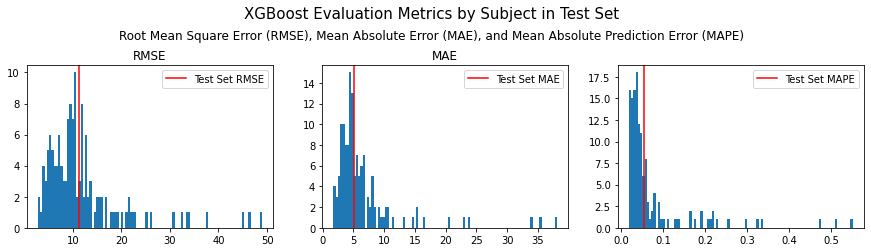

In [149]:
fig, axs = plt.subplots(1,3, sharey=False, figsize=(15,3))

indices = [(0,0), (0,1),(0,2)]
for idx, key in enumerate(metrics):
    ax = axs[idx]
    ax.hist(metrics[key], bins=100)
    ax.set_title(f"{key.upper()}")
    ax.axvline(full_metrics[key], color='red', label=f'Test Set {key.upper()}')
    ax.legend()
_ = plt.suptitle('XGBoost Evaluation Metrics by Subject in Test Set', y=1.15, fontsize=15)
_ = plt.title('Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Prediction Error (MAPE)',
              x=0.5, transform=fig.transFigure, fontsize=12)

In [157]:
test = []
for name, group in grouped:
    mse = mean_squared_error(group['y'], group['y_hat'])
    rmse = np.sqrt(mse)
#     mae = mean_absolute_error(group['y'], group['y_hat'])
#     mape = mean_absolute_percentage_error(group['y'], group['y_hat'])
    std_dev = np.std(group['y'])
#     print(std_dev)
    test.append((rmse, std_dev))
    

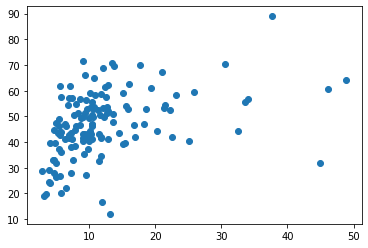

In [156]:
plt.scatter([x[0] for x in test], [x[1] for x in test])

## LSTM